In [2]:
%%capture
#!rm -Rf /home/peres/.cache/rootpy/*
%run "~/notebooks/power_on.ipynb"
%run "~/notebooks/function_definitions.ipynb"

cachefolder='/home/peres/minitrees/cache/UZH/ER_NR_discrimination/'

In [3]:
def FiducialCylinder1T(df):
    #print('\nProcessing and cutting FIducial1T\n')
    df['r'] = (df['x_nn']**2 + df['y_nn']**2)**.5
    df['CutFid1T'] = (df['z'] > -92.9) & (df['z'] < -9) & (df['r'] < 36.94)
    #df = df[df['Cutfid1T'] == True]
    
    return df

def get_gauss_bins(hist):
    ylist = hist[2]
    valuelist = hist[0]
    ybinsize = ylist[1]-ylist[0]
    ybins_middle = ylist[:-1] + ybinsize/2
    fits =[]
    for xbin in range(len(hist[1])-1):
        
        _values = valuelist[xbin]
        _cumsum = np.cumsum(_values)
        _totalsum = _cumsum[-1]
        _mean = np.sum(ybins_middle*_values)/_totalsum
        _dev = np.sqrt(np.sum(np.power(ybins_middle-_mean,2))/(_totalsum-1))
        
        _fitpar,_fiterr = curve_fit(gaussian,ybins_middle,_values,p0=[1,_mean,_dev])
        _err = []
        for i in range(len(_fiterr)):
            _err.append(np.sqrt(np.absolute(_fiterr[i][i])))
        #print(_fitpar, _err)
        fits.append(np.array([np.array(_fitpar),np.array(_err)]))
    return np.array(fits)

def process_gauss_df(df_cut,x_data,y_data, bins=30, rang=[[5,150],[0,3]]):
    hist = np.histogram2d(x_data,y_data,
                          bins=bins, range = rang)
    # Create a DataFrame to work with, first column is the middle of each x bin
    xmid = hist[1][:-1] + (hist[1][1]-hist[1][0])/2
    #print(len(xmid))
    df = pd.DataFrame(xmid, columns=['x_mid'])
    # Fit the values over y of each bin in x
    _fits = get_gauss_bins(hist)
    # Fill the DataFrame with the fit parameters
    #print(_fits.shape)
    df['mu'] = _fits[:,[0],[1]]
    df['mu_err'] = np.absolute(_fits[:,[1],[1]])
    df['sig'] = np.absolute(_fits[:,[0],[2]])
    df['sig_err'] = np.absolute(_fits[:,[1],[2]])
    df['mu+2sig'] = df['mu']+2*df['sig']
    df['mu+2sig_err'] = np.sqrt(np.power(df['mu_err'],2) + np.power(2*df['sig_err'],2))
    df['mu-2sig'] = df['mu']-2*df['sig']
    df['mu-2sig_err'] = np.sqrt(np.power(df['mu_err'],2) + np.power(2*df['sig_err'],2))
    return df

def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x-mu)**2 / (2*sigma**2))
    #return np.exp(-np.power((x-mu),2)/(2*np.power(sigma,2))) / np.sqrt(2*np.pi*np.power(sigma,2))

def plot_gaussfitpoints(df_cut,x_data,y_data, df_gauss,bins = 100,rang = [[1,150],[0,3]], tag='', save_fig=False):
    plt.figure(figsize = (10,6))
    plt.hist2d(x_data,y_data, 
                    bins=bins, norm=LogNorm(), range = rang, cmap='winter', alpha =0.4)
    plt.colorbar()
    plt.plot(df_gauss['x_mid'], df_gauss['mu'], marker = '.',color = 'orange' ,label='median', linestyle='')
    plt.plot(df_gauss['x_mid'], df_gauss['mu-2sig'],'r.', label='-2 sigma',  linestyle='')
    plt.plot(df_gauss['x_mid'], df_gauss['mu+2sig'],'r.', label = '+2 sigma', linestyle='')

    plt.legend(fontsize = 13,frameon=False)
    #plt.ylabel('log10(cS2_b / cS1)')
    #plt.xlabel('cS1')
    if save_fig == True:
        plt.savefig('./figures/%sgaussfitpoints_%s.png'%(tag,df_cut.name), bbox_inches='tight')
        print('Figure saved')
        plt.show()
    elif save_fig == False:
        plt.show()
        
def expon(x,a,tau,b,c):
    return a * np.exp(-(x-b)*tau) + c

def linear(x,a,c):
    return a*x + c

In [4]:
%%capture
hax.init(experiment='XENON1T',
         pax_version_policy = 'v6.10.1',
         main_data_paths= ['/dali/lgrandi/xenon1t/processed/pax_v6.10.1/'], #'/project/lgrandi/xenon1t/processed/latest/'
         minitree_paths = ['/dali/lgrandi/xenon1t/minitrees/pax_v6.10.1/','/home/peres/minitrees'], #'/project/lgrandi/xenon1t/minitrees/latest/',
        make_minitrees = False)
print('Using hax version'+str(hax.__version__)+'\n')

hax.minitrees.TreeMaker.mc_data = False

In [5]:
datasets = hax.runs.datasets
dataset_select = datasets[(datasets['source__type']==('Kr83m')) &
                          (datasets['start'] > pd.to_datetime('20181013', format='%Y%m%d', errors='ignore')) &
                          (datasets['start'] < pd.to_datetime('20181016', format='%Y%m%d', errors='ignore'))
                         ]
dataset_select = hax.runs.tags_selection(dsets=dataset_select, exclude=['source_opening','Flash','ramping'])
len(dataset_select)

37

In [6]:
run_numbers = dataset_select['number'].values
tmakers = ['Fundamentals', 'Basics', 'Extended', 'CorrectedDoubleS1Scatter', 'TotalProperties','Corrections']
kr = hax.minitrees.load(run_numbers, treemakers = tmakers)

Currently, the e-lifetimes (used by Zach) are :

 * extracted from the uncorrected S2_total
 * the range of fit is within the 150 - 600 $\mu$s interval
 * the FV from SR0 is used

the following cut selection to isolate “good Kr83m events” (i.e with 2 distinct S1s corresponding to the 32 keV and 9 keV lines and one S2 corresponding to the sum at 41 keV) events on the new Double Scatter Correction minitrees is applied :
 * 500 < (s1_b_center_time-s1_a_center_time) <2000 ns
 * 3 < ds_s1_b_n_distinct_channels < 30
 * Fiducial Volume cut

In [7]:
kr['CutBinCenter'] = (((kr['s1_b_center_time']-kr['s1_a_center_time']) > 500) & 
                      ((kr['s1_b_center_time']-kr['s1_a_center_time']) < 2000))
kr['CutDistinctChannels'] = ((kr['ds_s1_b_n_distinct_channels'] > 3) & 
                      (kr['ds_s1_b_n_distinct_channels'] < 30))
kr = FiducialCylinder1T(kr)

In [ ]:
kr.columns.values

In [15]:
kr_cut = kr.copy()
cutL = ['CutBinCenter','CutDistinctChannels','CutFid1T']
for name in cutL:
    kr_cut = cuts.selection(kr_cut, kr_cut[name], name)

CutBinCenter selection: 850775 rows removed (3.42% passed)
CutDistinctChannels selection: 15637 rows removed (48.14% passed)
CutFid1T selection: 5098 rows removed (64.87% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


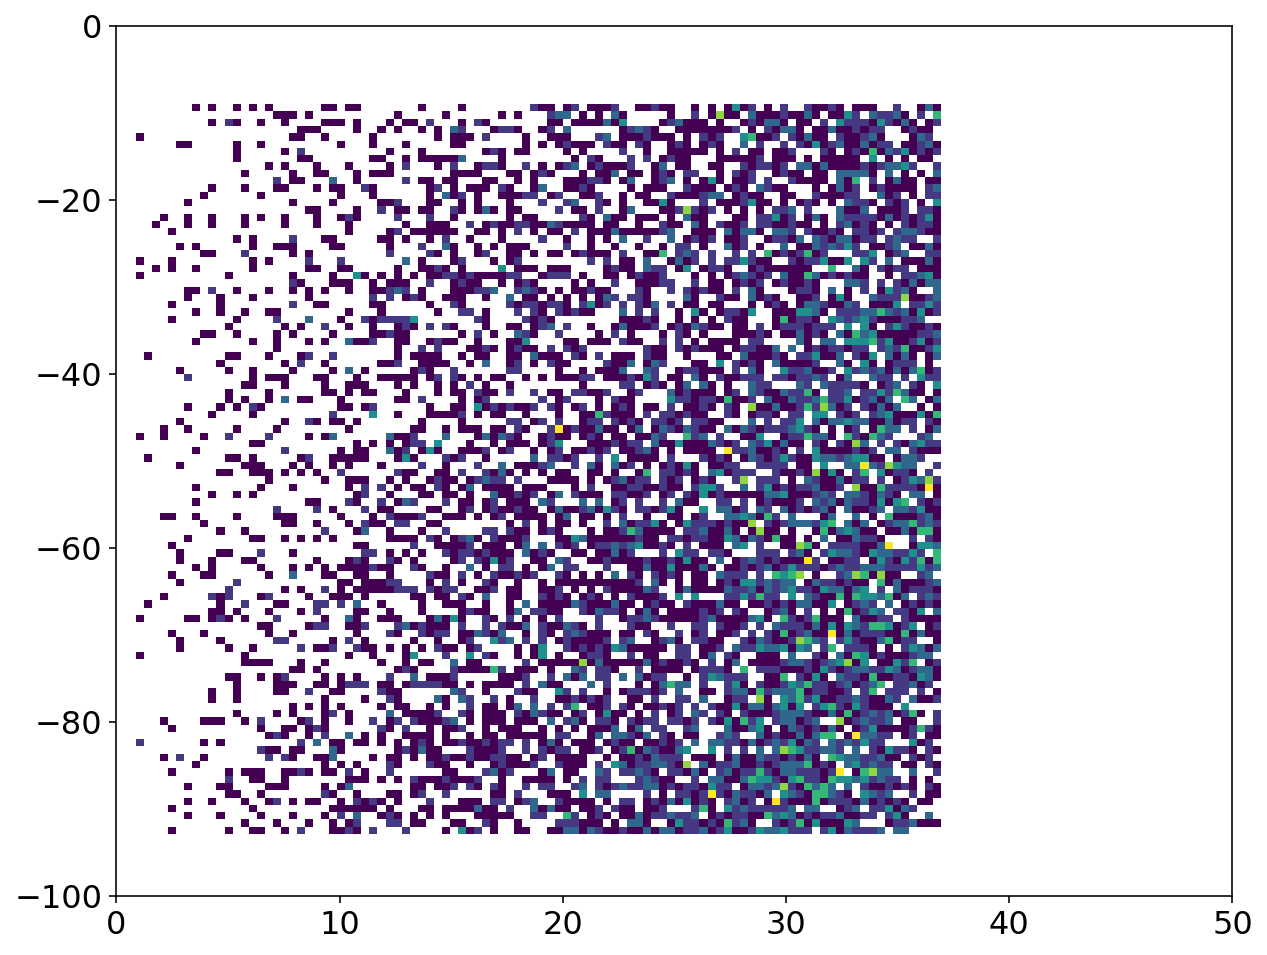

In [44]:
plt.hist2d(kr_cut['r'],kr_cut['z'],bins = 100,cmin = 1)
plt.xlim(0,50)
plt.ylim(-100,0)
plt.show()

In [17]:
hax.cuts.history(kr_cut)

selection_desc  n_before  n_after  n_removed  fraction_passed  cumulative_fraction_left
0         CutBinCenter    880925    30150     850775         0.034225                  0.034225
1  CutDistinctChannels     30150    14513      15637         0.481360                  0.016475
2             CutFid1T     14513     9415       5098         0.648729                  0.010688

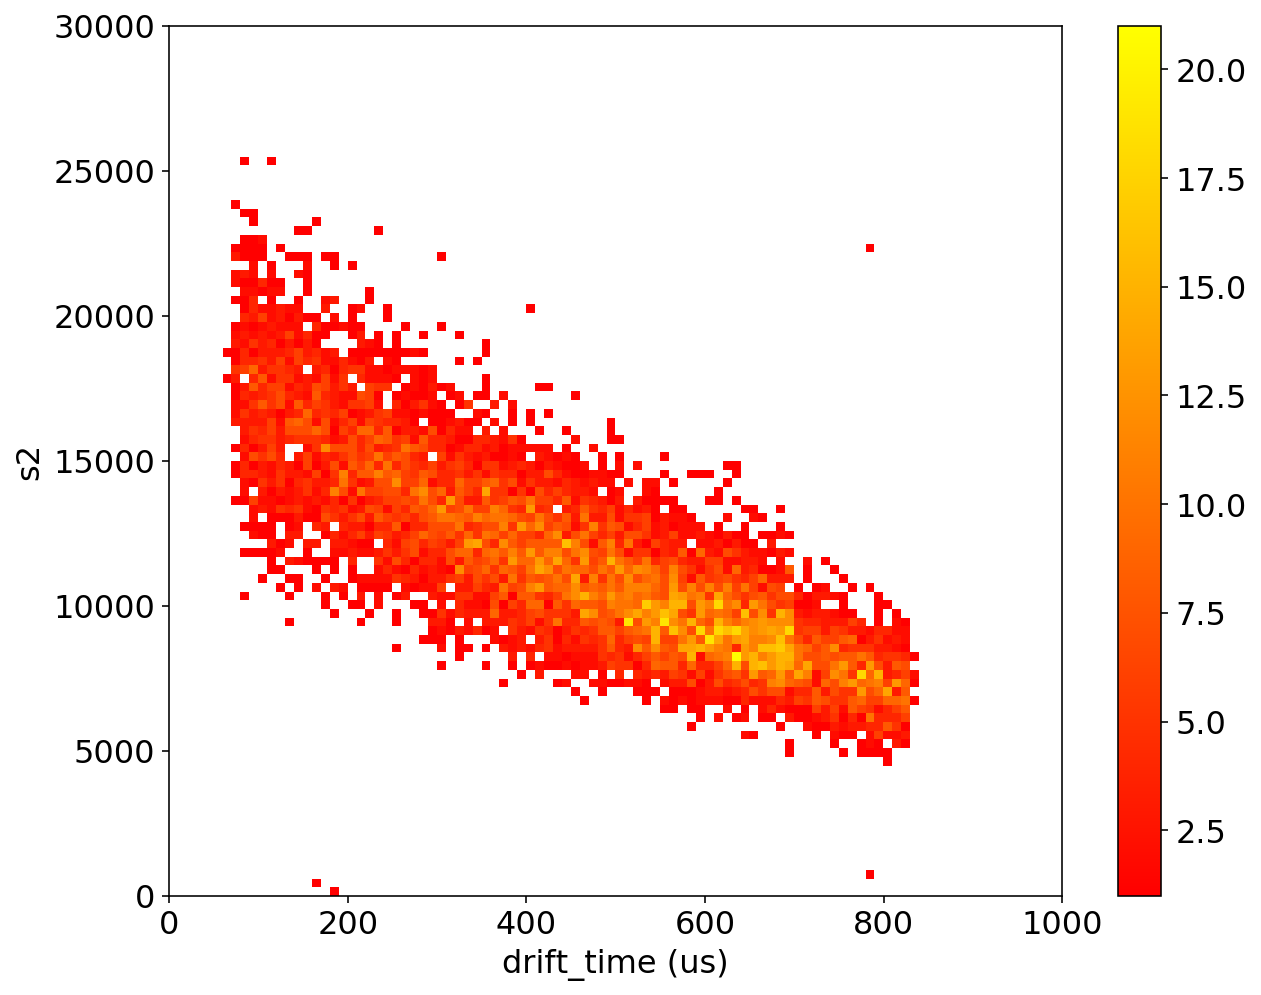

In [18]:
#drift_time is in "ns"
plt.hist2d(x=kr_cut['drift_time']/1000,y=kr_cut['s2'], bins = 100, range = ((0,1000),(0,30000)),cmin = 1, cmap= 'autumn')
plt.xlabel('drift_time (us)')
plt.ylabel('s2')
plt.colorbar()
plt.savefig('./figures/corrections_EL_lowfield.png' , bbox_inches='tight')
plt.show()

In [19]:
kr_gauss_df = process_gauss_df(kr_cut,x_data = kr_cut['drift_time']/1000, y_data = kr_cut['s2'], bins = 100, rang=((120,650),(0,30000)))

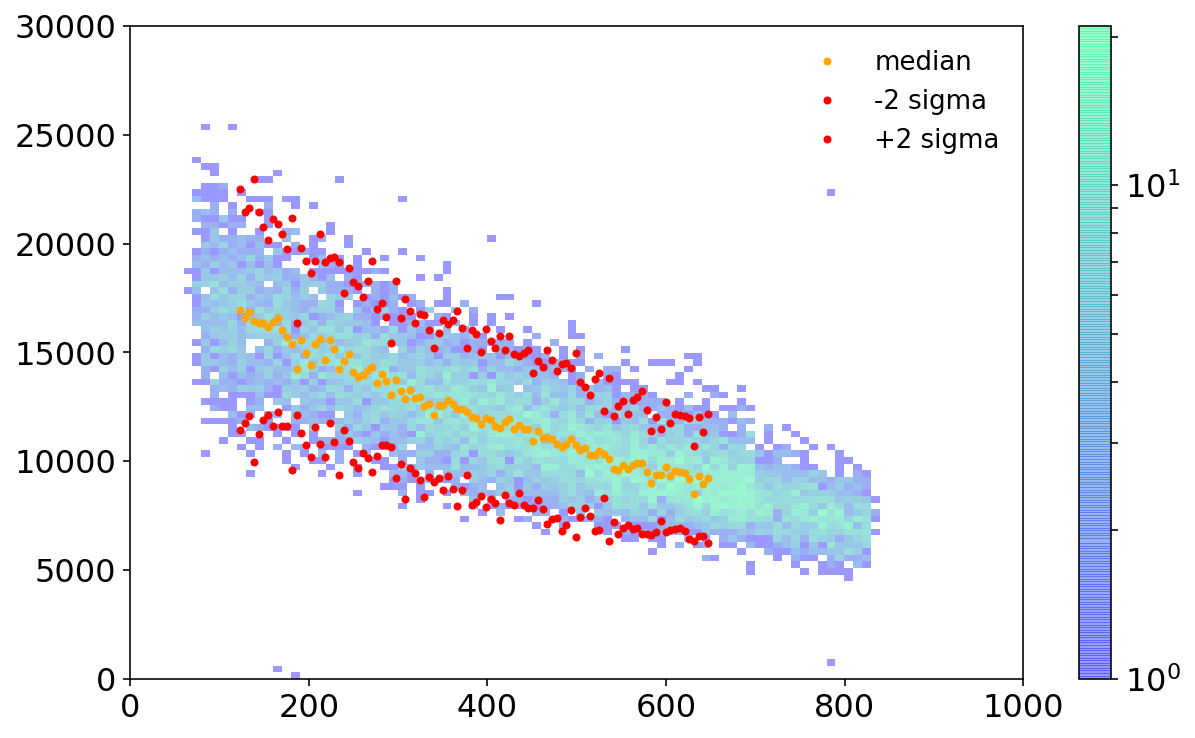

In [20]:
plot_gaussfitpoints(df_cut=kr_cut, df_gauss=kr_gauss_df,rang=((0,1000),(0,30000)),bins = 100,x_data=kr_cut['drift_time']/1000,y_data=kr_cut['s2'])

In [21]:
med_fit, med_err = curve_fit(linear,kr_gauss_df['x_mid'], kr_gauss_df['mu'])

In [22]:
med_fit 

array([ -1.48982762e+01,   1.81034839e+04])

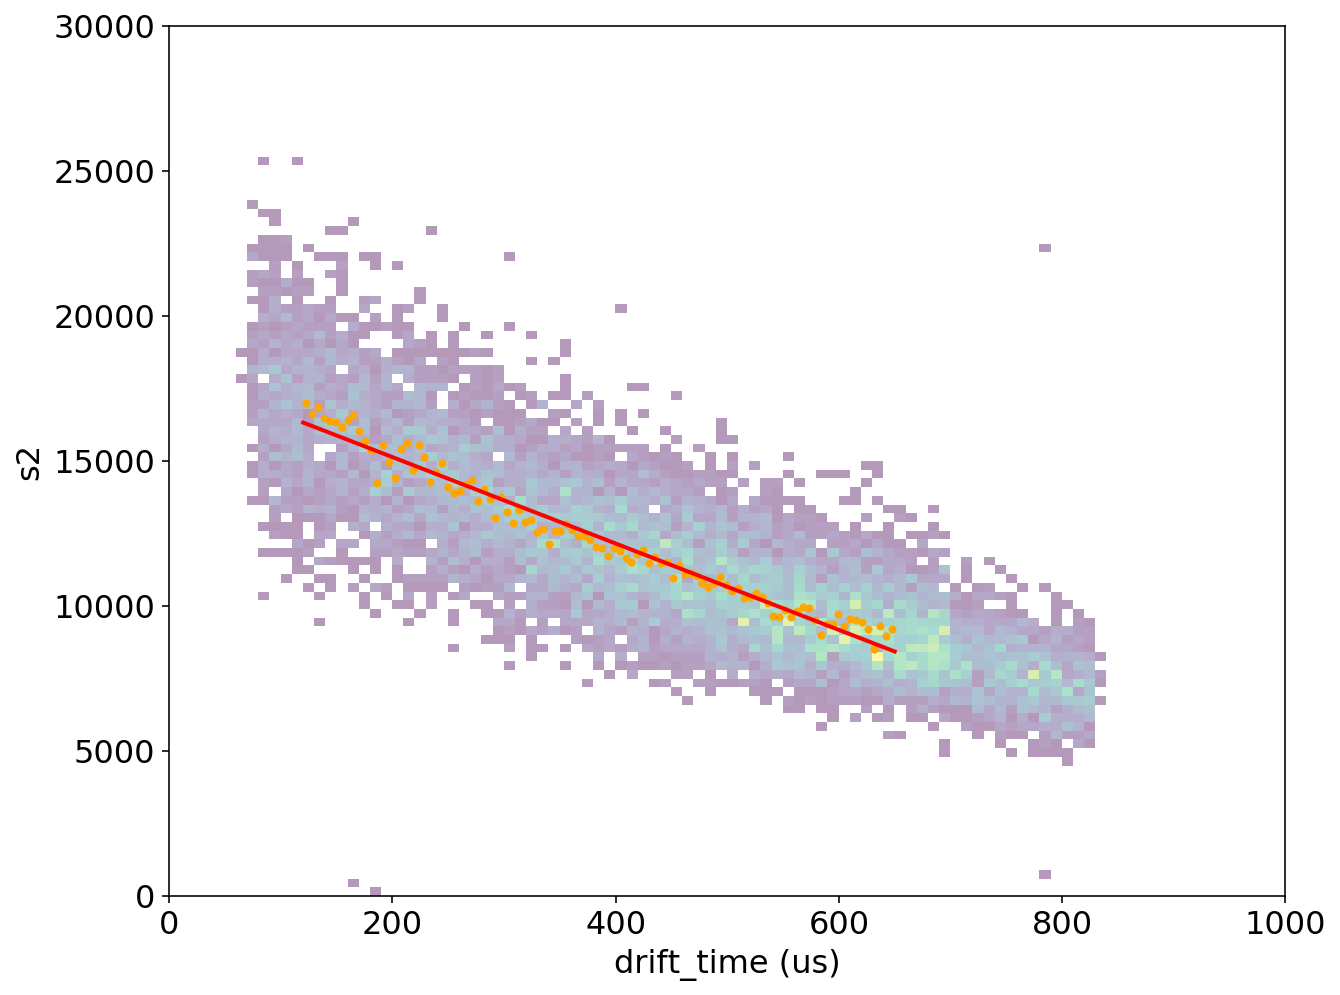

In [23]:
#drift_time is in "ns"
plt.hist2d(x=kr_cut['drift_time']/1000,y=kr_cut['s2'], bins = 100, range = ((0,1000),(0,30000)),cmin = 1,alpha = 0.4)
plt.xlabel('drift_time (us)')
plt.ylabel('s2')
plt.plot(kr_gauss_df['x_mid'], kr_gauss_df['mu'], marker = '.',color = 'orange' ,label='median', linestyle='')

x = np.linspace (120,650,1000)
plt.plot(x,linear(x,med_fit[0],med_fit[1]),ls='-', color = 'red', lw = 2)
plt.show()

In [24]:
print('lifetime = %f us' %(-1/med_fit[0]))

lifetime = 0.067122 us


## check cs2 and cs1 spacial dependance

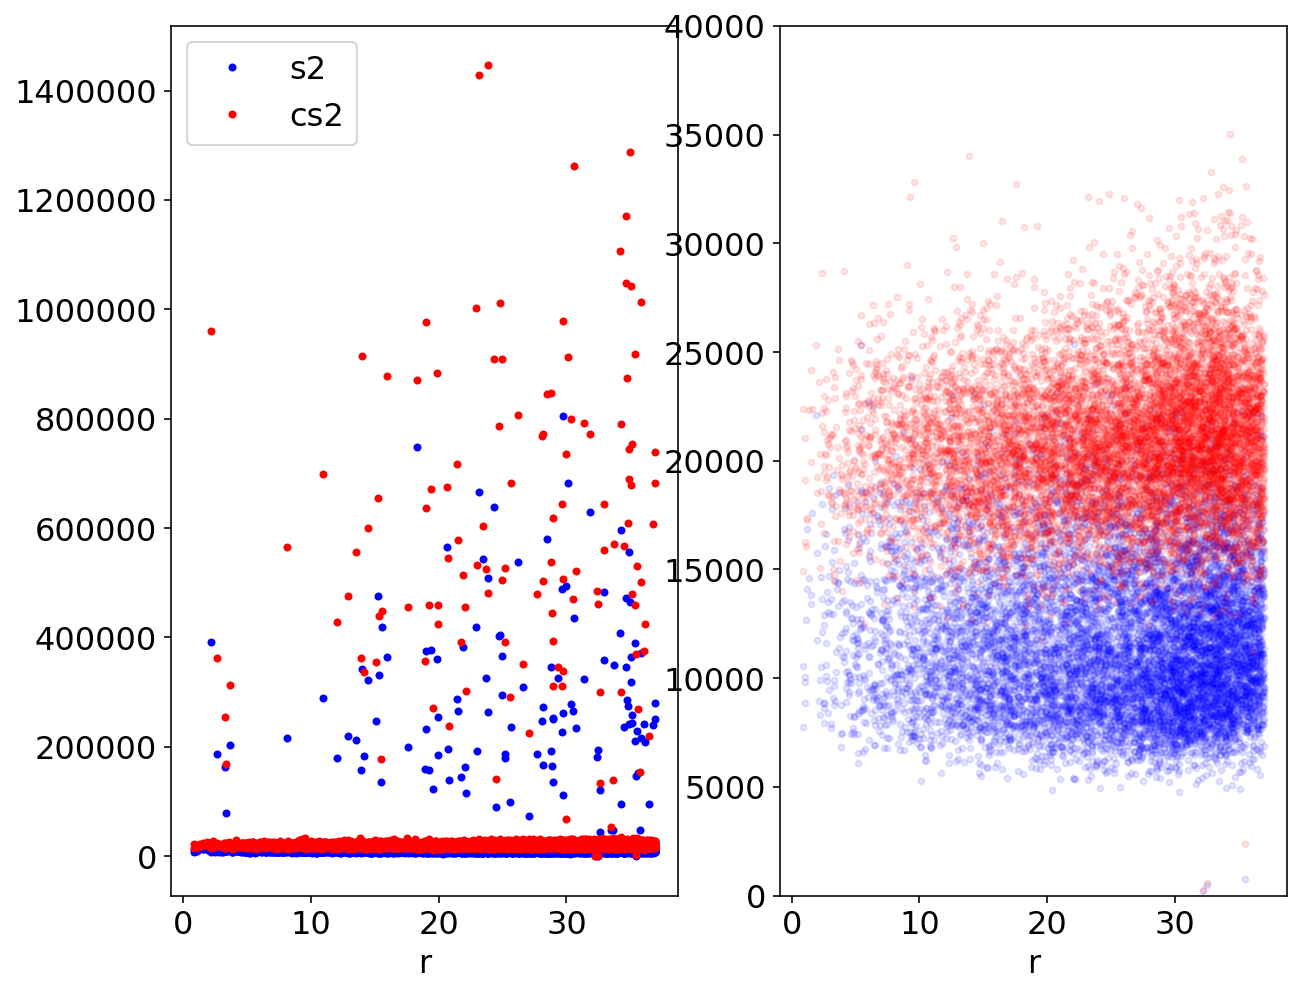

In [25]:
plt.subplot(121)
plt.plot(kr_cut['r'],kr_cut['s2'],'.b',label = 's2')
plt.plot(kr_cut['r'],kr_cut['cs2'],'.r', label = 'cs2')
plt.legend()
plt.xlabel('r')

plt.subplot(122)
plt.plot(kr_cut['r'],kr_cut['s2'],'.b',alpha = 0.1,label = 's2')
plt.plot(kr_cut['r'],kr_cut['cs2'],'.r',alpha = 0.1, label = 'cs2')
plt.ylim(0,40000)
plt.xlabel('r')
plt.savefig('./figures/corrections_cs2_s2_r_lowfield.png' , bbox_inches='tight')
plt.show()

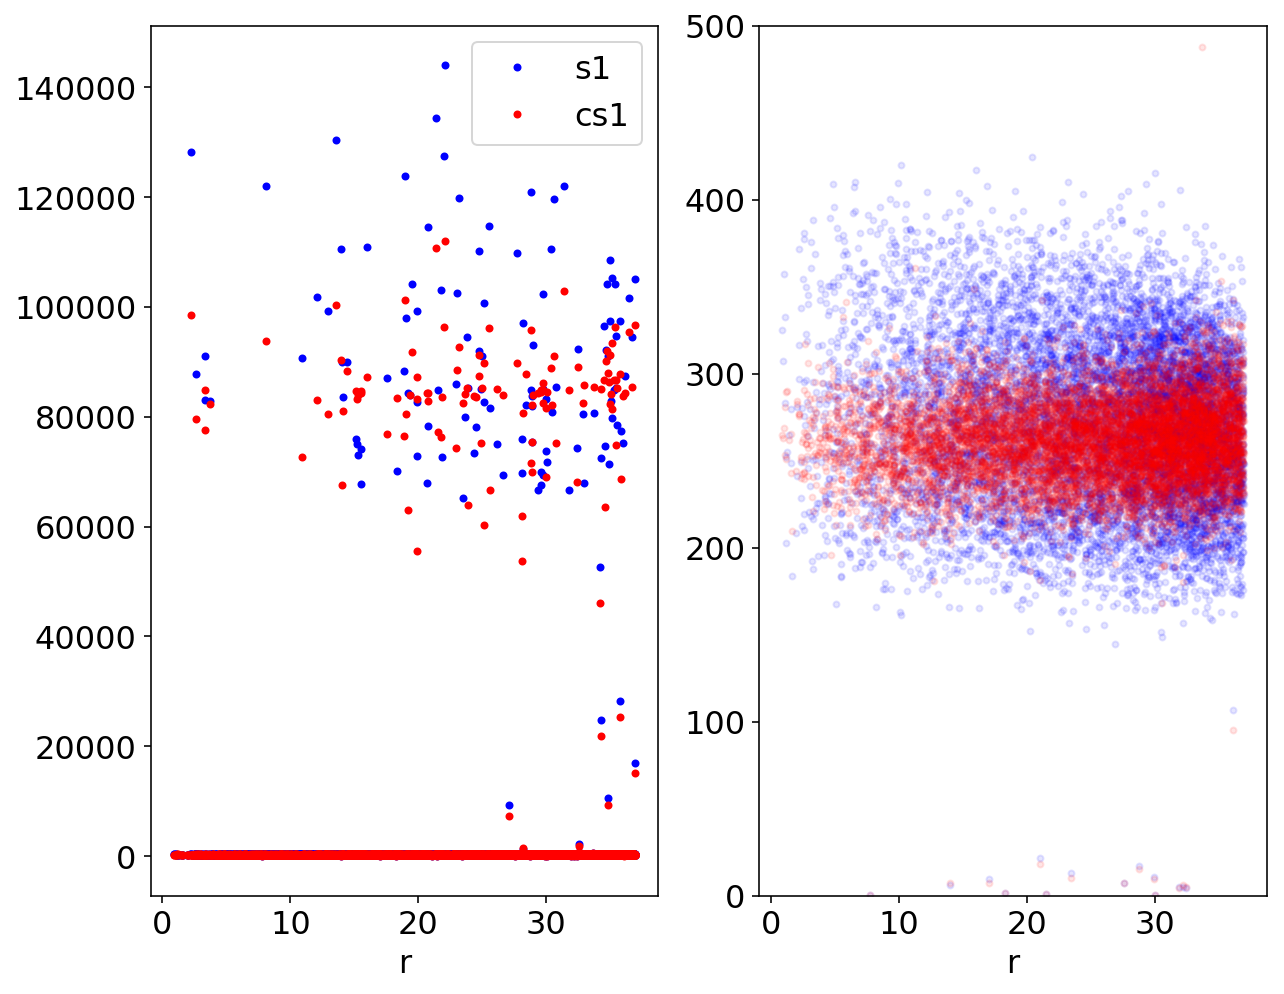

In [26]:
plt.subplot(121)
plt.plot(kr_cut['r'],kr_cut['s1'],'.b',label = 's1')
plt.plot(kr_cut['r'],kr_cut['cs1'],'.r', label = 'cs1')
plt.legend()
plt.xlabel('r')

plt.subplot(122)
plt.plot(kr_cut['r'],kr_cut['s1'],'.b',alpha = 0.1,label = 's1')
plt.plot(kr_cut['r'],kr_cut['cs1'],'.r',alpha = 0.1, label = 'cs1')
plt.ylim(0,500)
plt.xlabel('r')
plt.savefig('./figures/corrections_cs1_s1_r_lowfield.png' , bbox_inches='tight')

plt.show()

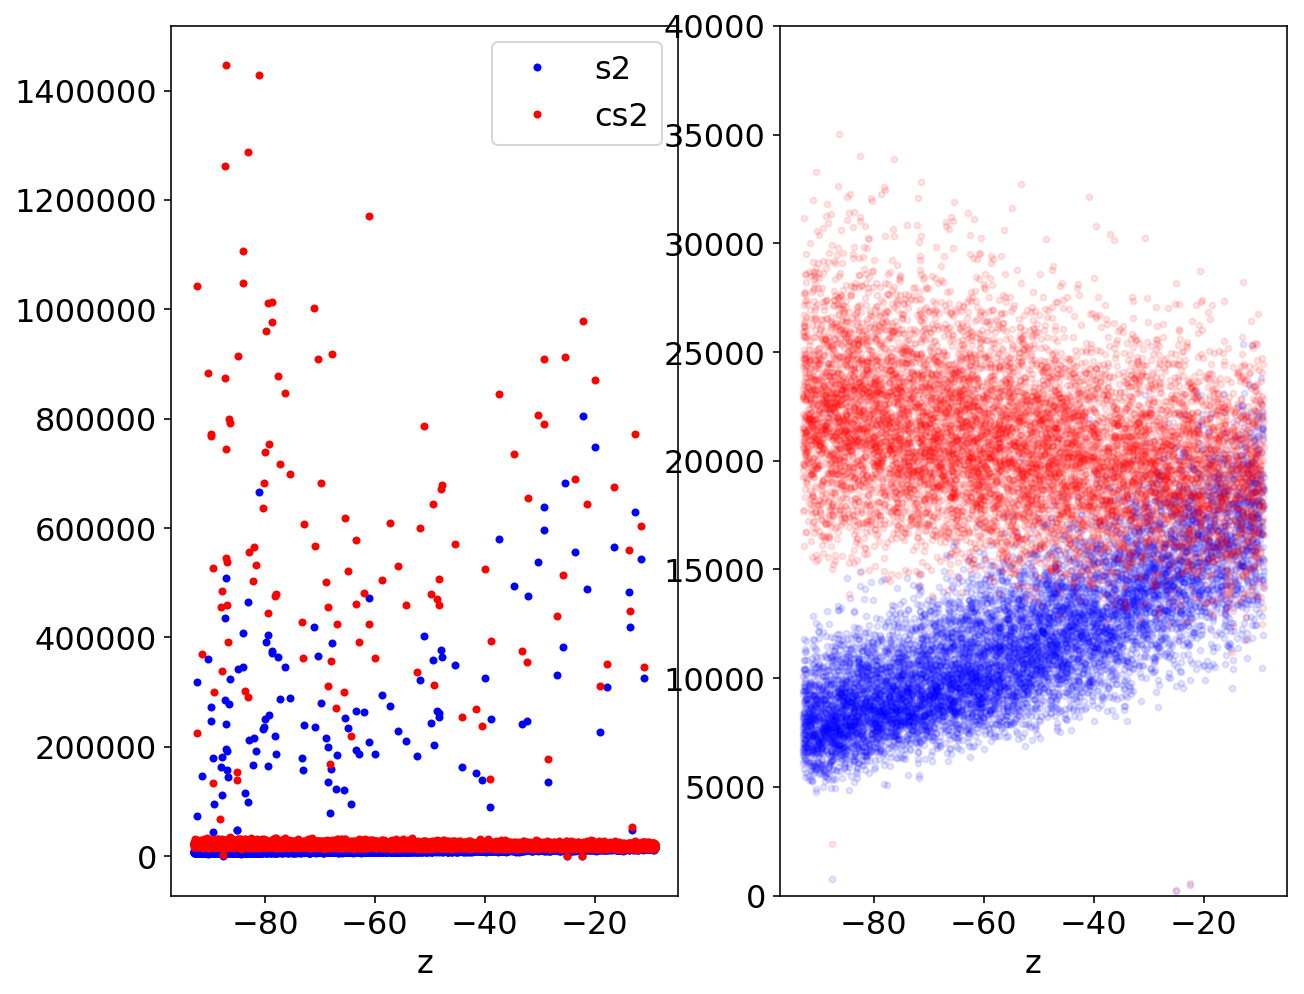

In [27]:
plt.subplot(121)
plt.plot(kr_cut['z'],kr_cut['s2'],'.b',label = 's2')
plt.plot(kr_cut['z'],kr_cut['cs2'],'.r', label = 'cs2')
plt.legend()
plt.xlabel('z')

plt.subplot(122)
plt.plot(kr_cut['z'],kr_cut['s2'],'.b',alpha = 0.1,label = 's2')
plt.plot(kr_cut['z'],kr_cut['cs2'],'.r',alpha = 0.1, label = 'cs2')
plt.ylim(0,40000)
plt.xlabel('z')
plt.savefig('./figures/corrections_cs2_s2_z_lowfield.png' , bbox_inches='tight')
plt.show()

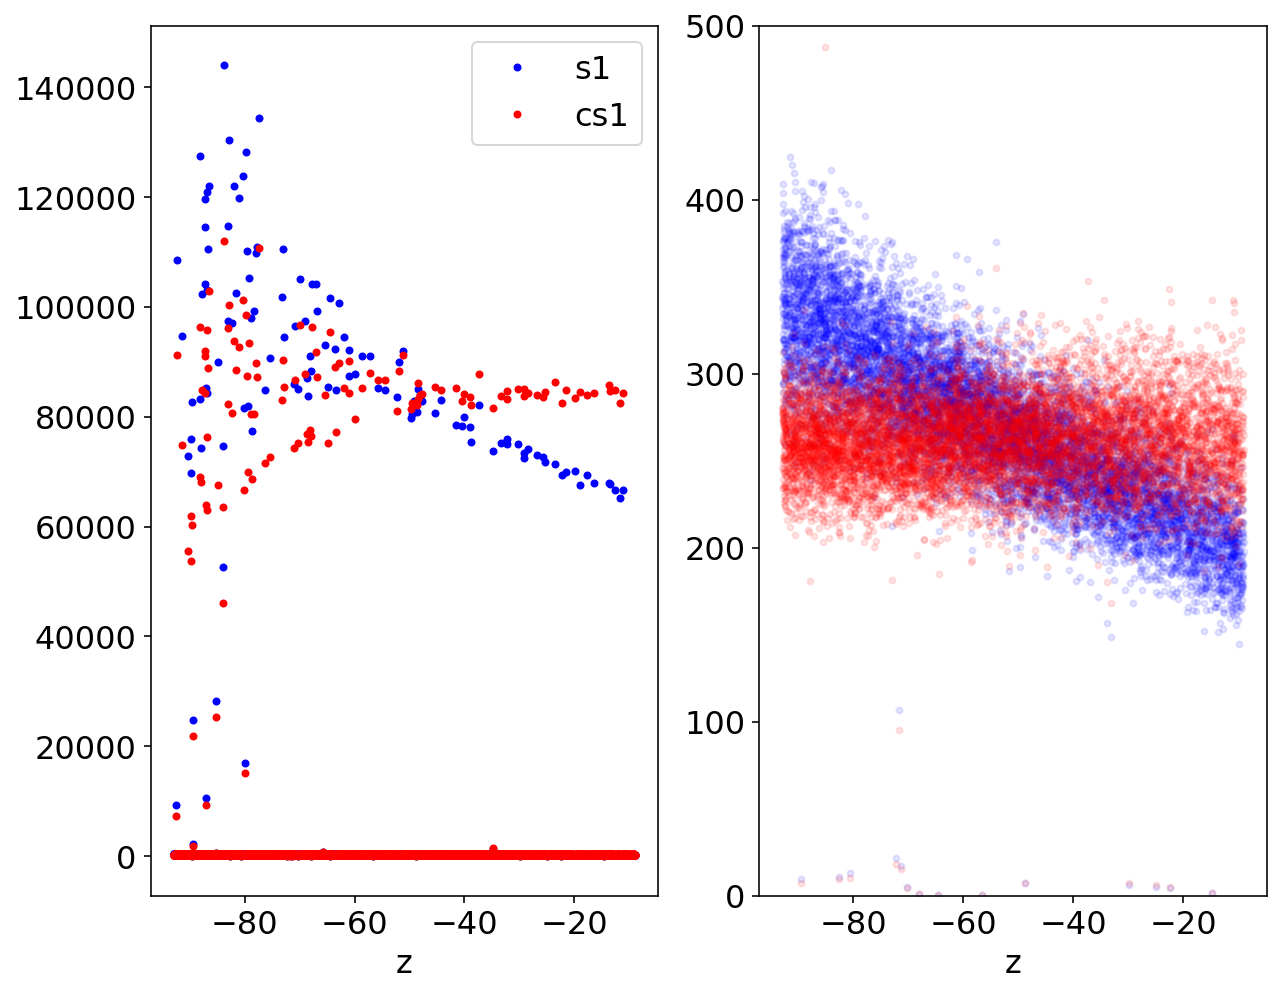

In [28]:
plt.subplot(121)
plt.plot(kr_cut['z'],kr_cut['s1'],'.b',label = 's1')
plt.plot(kr_cut['z'],kr_cut['cs1'],'.r', label = 'cs1')
plt.legend()
plt.xlabel('z')

plt.subplot(122)
plt.plot(kr_cut['z'],kr_cut['s1'],'.b',alpha = 0.1,label = 's1')
plt.plot(kr_cut['z'],kr_cut['cs1'],'.r',alpha = 0.1, label = 'cs1')
plt.ylim(0,500)
plt.xlabel('z')
plt.savefig('./figures/corrections_cs1_s1_z_lowfield.png' , bbox_inches='tight')

plt.show()

In [29]:
datasets = hax.runs.datasets
dataset_select = datasets[(datasets['source__type']==('Kr83m'))]
dataset_select = hax.runs.tags_selection(dsets=dataset_select,include='sciencerun1', exclude=['source_opening','Flash','ramping'])
len(dataset_select)

451

In [30]:
dataset_select.tail(30)

end                                           location         name  number pax_version reader__ini__name  reader__self_trigger  source__frequency source__type               start                                               tags  trigger__events_built trigger__status raw_data_subfolder  raw_data_found raw_data_used_local_path
16273 2018-01-23 22:08:19  /dali/lgrandi/xenon1t/processed/pax_v6.10.1/18...  180123_2108   16276      6.10.1      kr83m_stable                  True                NaN        Kr83m 2018-01-23 21:08:16                _sciencerun1_candidate,_sciencerun1                57887.0         deleted                              False                         
16274 2018-01-23 23:08:30  /dali/lgrandi/xenon1t/processed/pax_v6.10.1/18...  180123_2208   16277      6.10.1      kr83m_stable                  True                NaN        Kr83m 2018-01-23 22:08:26                _sciencerun1_candidate,_sciencerun1                57899.0         deleted                              False                         
16275 2018-01-24 00:08:39  /dali/lgrandi/xenon1t/processed/pax_v6.10.1/18...  180123_2308   16278      6.10.1      kr83m_stable                  True                NaN        Kr83m 2018-01-23 23:08:37                _sciencerun1_candidate,_sciencerun1                57998.0         deleted                              False                         
16276 2018-01-24 01:08:50  /dali/lgrandi/xenon1t/processed/pax_v6.10.1/18...  180124_0008   16279      6.10.1      kr83m_stable                  True                NaN        Kr83m 2018-01-24 00:08:47                _sciencerun1_candidate,_sciencerun1                58252.0         deleted                              False                         
16277 2018-01-24 02:09:01  /dali/lgrandi/xenon1t/processed/pax_v6.10.1/18...  180124_0108   16280      6.10.1      kr83m_stable                  True                NaN        Kr83m 2018-01-24 01:08:57                _sciencerun1_candidate,_sciencerun1                58475.0         deleted                              False                         
16278 2018-01-24 03:09:12  /dali/lgrandi/xenon1t/processed/pax_v6.10.1/18...  180124_0209   16281      6.10.1      kr83m_stable                  True                NaN        Kr83m 2018-01-24 02:09:08                _sciencerun1_candidate,_sciencerun1                58173.0         deleted                              False                         
16279 2018-01-24 04:09:23  /dali/lgrandi/xenon1t/processed/pax_v6.10.1/18...  180124_0309   16282      6.10.1      kr83m_stable                  True                NaN        Kr83m 2018-01-24 03:09:19                _sciencerun1_candidate,_sciencerun1                58049.0         deleted                              False                         
16280 2018-01-24 05:09:34  /dali/lgrandi/xenon1t/processed/pax_v6.10.1/18...  180124_0409   16283      6.10.1      kr83m_stable                  True                NaN        Kr83m 2018-01-24 04:09:30                _sciencerun1_candidate,_sciencerun1                58267.0         deleted                              False                         
16281 2018-01-24 06:09:43  /dali/lgrandi/xenon1t/processed/pax_v6.10.1/18...  180124_0509   16284      6.10.1      kr83m_stable                  True                NaN        Kr83m 2018-01-24 05:09:42                _sciencerun1_candidate,_sciencerun1                58240.0         deleted                              False                         
16282 2018-01-24 07:09:58  /dali/lgrandi/xenon1t/processed/pax_v6.10.1/18...  180124_0609   16285      6.10.1      kr83m_stable                  True                NaN        Kr83m 2018-01-24 06:09:55                _sciencerun1_candidate,_sciencerun1                58192.0         deleted                              False                         
16283 2018-01-24 08:10:09  /dali/lgrandi/xenon1t/processed/pax_v6.10.1/18...  180124_0710   16286      6.10.1      kr83m_stable                  True 

In [31]:
dataset_select = dataset_select[-30:]

In [32]:
run_numbers = dataset_select['number'].values
tmakers = ['Fundamentals', 'Basics', 'Extended', 'CorrectedDoubleS1Scatter', 'TotalProperties','Corrections']
_dfs = []
badruns = []
for run in run_numbers:
    try:
        _kr_sr1 = hax.minitrees.load(run, treemakers = tmakers)
        _dfs.append(_kr_sr1)
    except:
        badruns.append(run)
kr_sr1 = pd.concat(_dfs)

In [33]:
kr_sr1 = pd.concat(_dfs)

In [34]:
kr_sr1['CutBinCenter'] = (((kr_sr1['s1_b_center_time']-kr_sr1['s1_a_center_time']) > 500) & 
                      ((kr_sr1['s1_b_center_time']-kr_sr1['s1_a_center_time']) < 2000))
kr_sr1['CutDistinctChannels'] = ((kr_sr1['ds_s1_b_n_distinct_channels'] > 3) & 
                      (kr_sr1['ds_s1_b_n_distinct_channels'] < 30))
kr_sr1 = FiducialCylinder1T(kr_sr1)

In [35]:
kr_sr1_cut = kr_sr1.copy()
cutL = ['CutBinCenter','CutDistinctChannels','CutFid1T']
for name in cutL:
    kr_sr1_cut = cuts.selection(kr_sr1_cut, kr_sr1_cut[name], name).copy()


CutBinCenter selection: 1022315 rows removed (6.40% passed)
CutDistinctChannels selection: 27341 rows removed (60.92% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


CutFid1T selection: 13955 rows removed (67.25% passed)


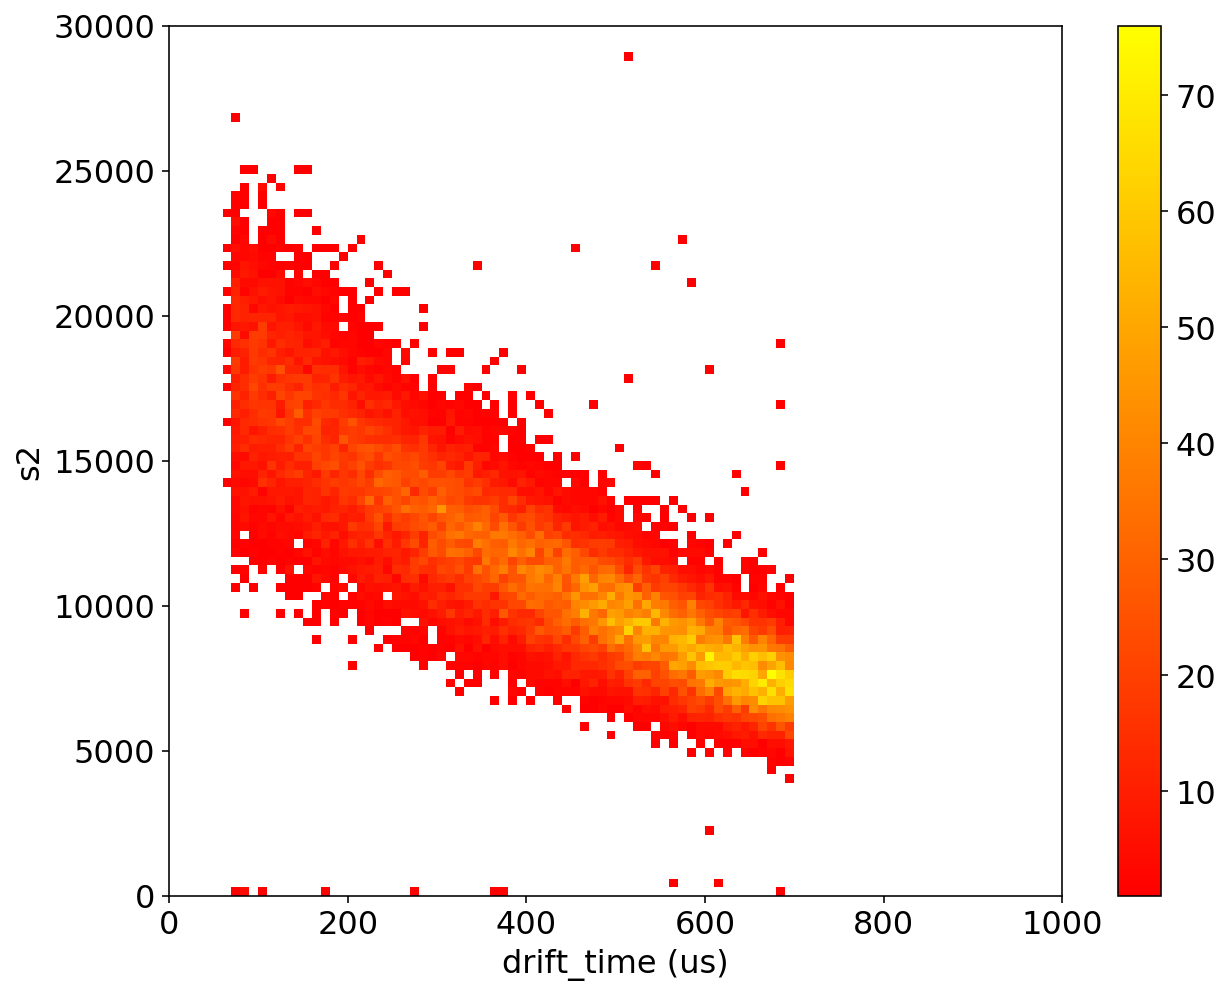

In [36]:
#drift_time is in "ns"
plt.hist2d(x=kr_sr1_cut['drift_time']/1000,y=kr_sr1_cut['s2'], bins = 100, range = ((0,1000),(0,30000)),cmin = 1, cmap= 'autumn')
plt.xlabel('drift_time (us)')
plt.ylabel('s2')
plt.colorbar()
plt.savefig('./figures/corrections_EL_sr1.png' , bbox_inches='tight')
plt.show()

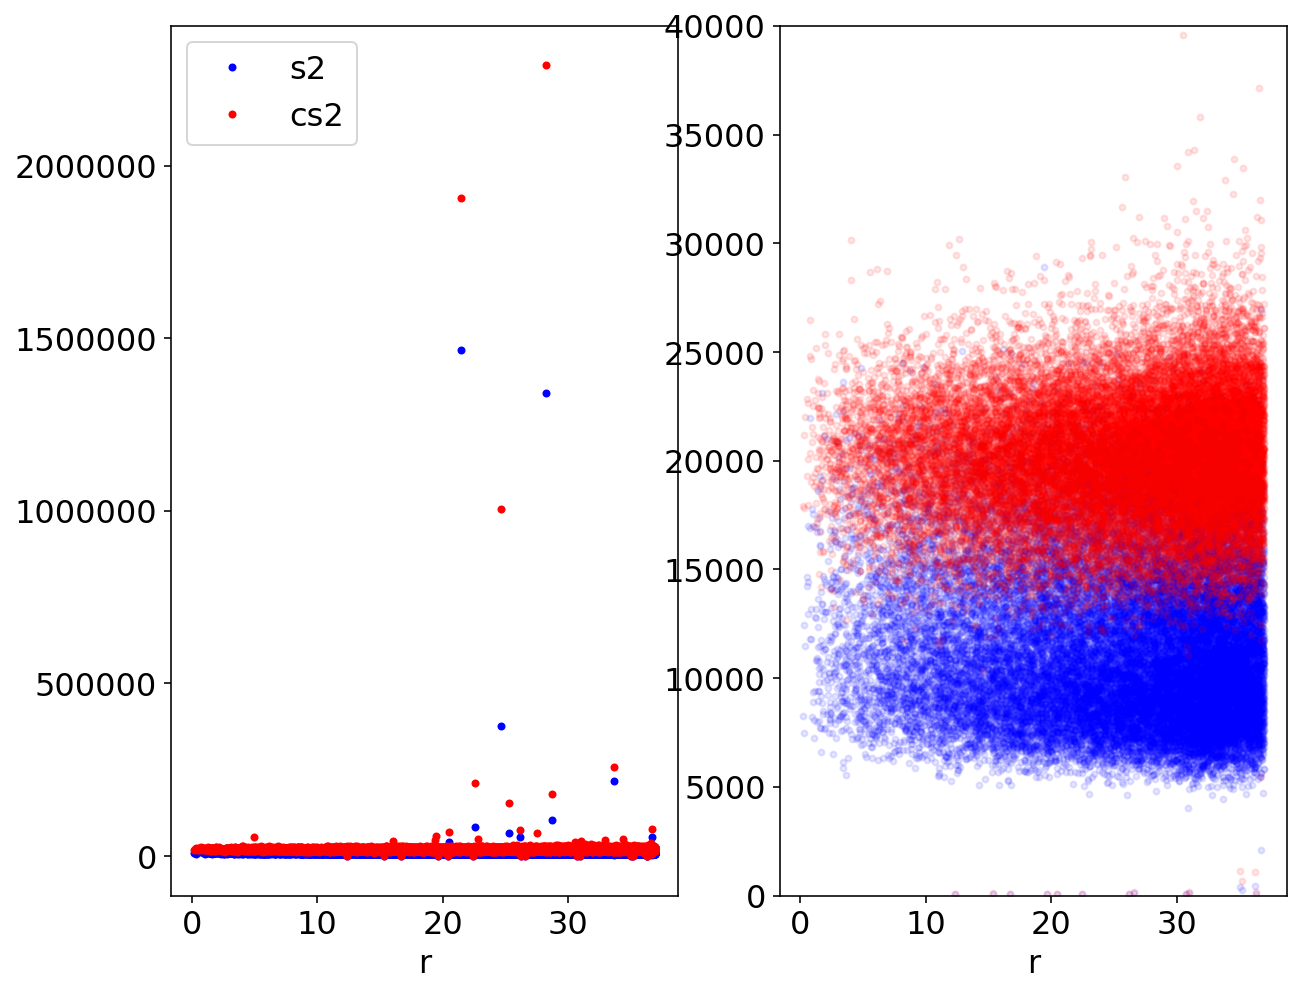

In [37]:
plt.subplot(121)
plt.plot(kr_sr1_cut['r'],kr_sr1_cut['s2'],'.b',label = 's2')
plt.plot(kr_sr1_cut['r'],kr_sr1_cut['cs2'],'.r', label = 'cs2')
plt.legend()
plt.xlabel('r')

plt.subplot(122)
plt.plot(kr_sr1_cut['r'],kr_sr1_cut['s2'],'.b',alpha = 0.1,label = 's2')
plt.plot(kr_sr1_cut['r'],kr_sr1_cut['cs2'],'.r',alpha = 0.1, label = 'cs2')
plt.ylim(0,40000)
plt.xlabel('r')
plt.savefig('./figures/corrections_cs2_s2_sr1.png' , bbox_inches='tight')

plt.show()

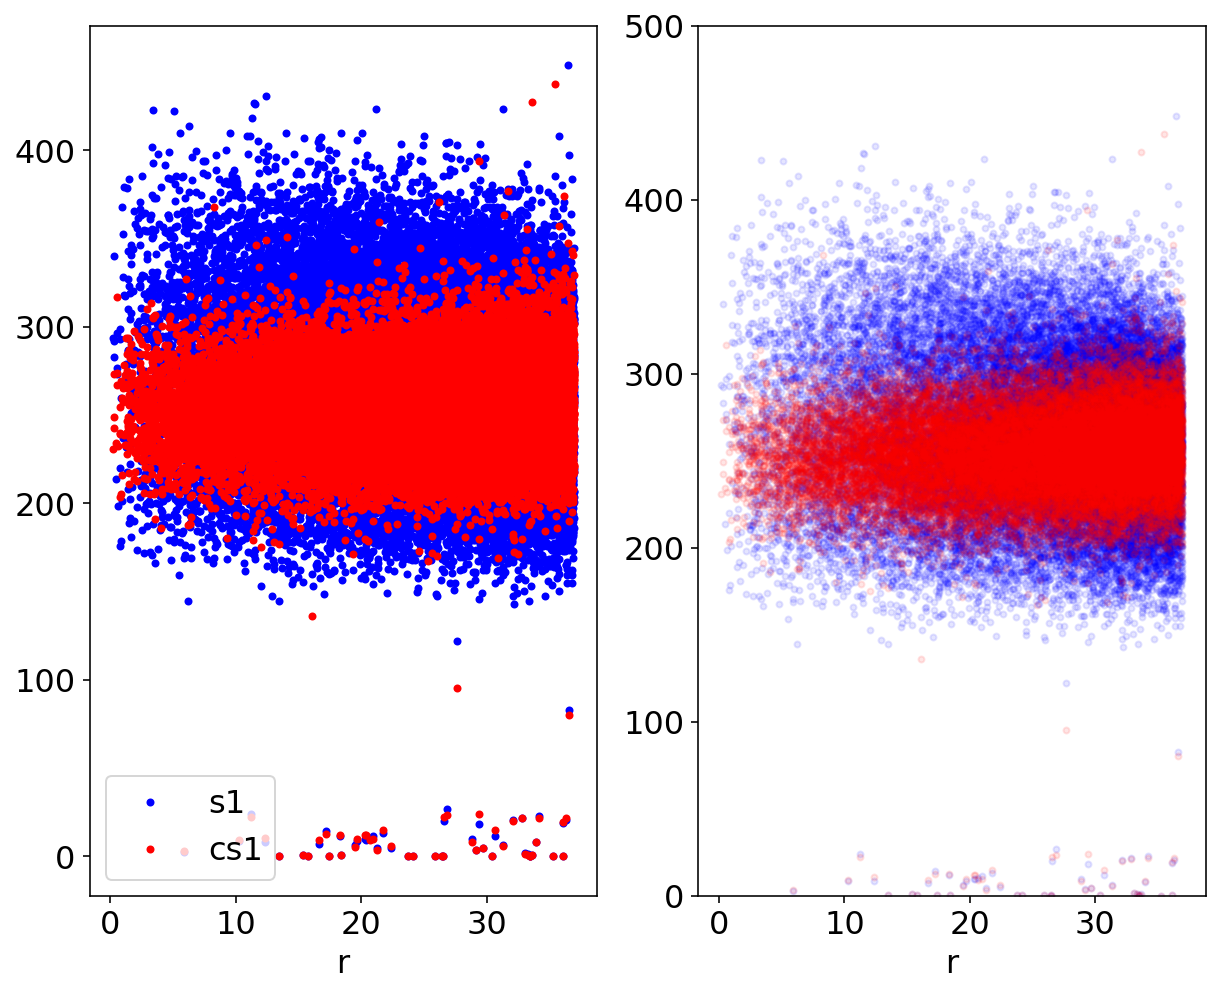

In [38]:
plt.subplot(121)
plt.plot(kr_sr1_cut['r'],kr_sr1_cut['s1'],'.b',label = 's1')
plt.plot(kr_sr1_cut['r'],kr_sr1_cut['cs1'],'.r', label = 'cs1')
plt.legend()
plt.xlabel('r')

plt.subplot(122)
plt.plot(kr_sr1_cut['r'],kr_sr1_cut['s1'],'.b',alpha = 0.1,label = 's1')
plt.plot(kr_sr1_cut['r'],kr_sr1_cut['cs1'],'.r',alpha = 0.1, label = 'cs1')
plt.ylim(0,500)
plt.xlabel('r')
plt.savefig('./figures/corrections_cs1_s1_sr1.png' , bbox_inches='tight')

plt.show()

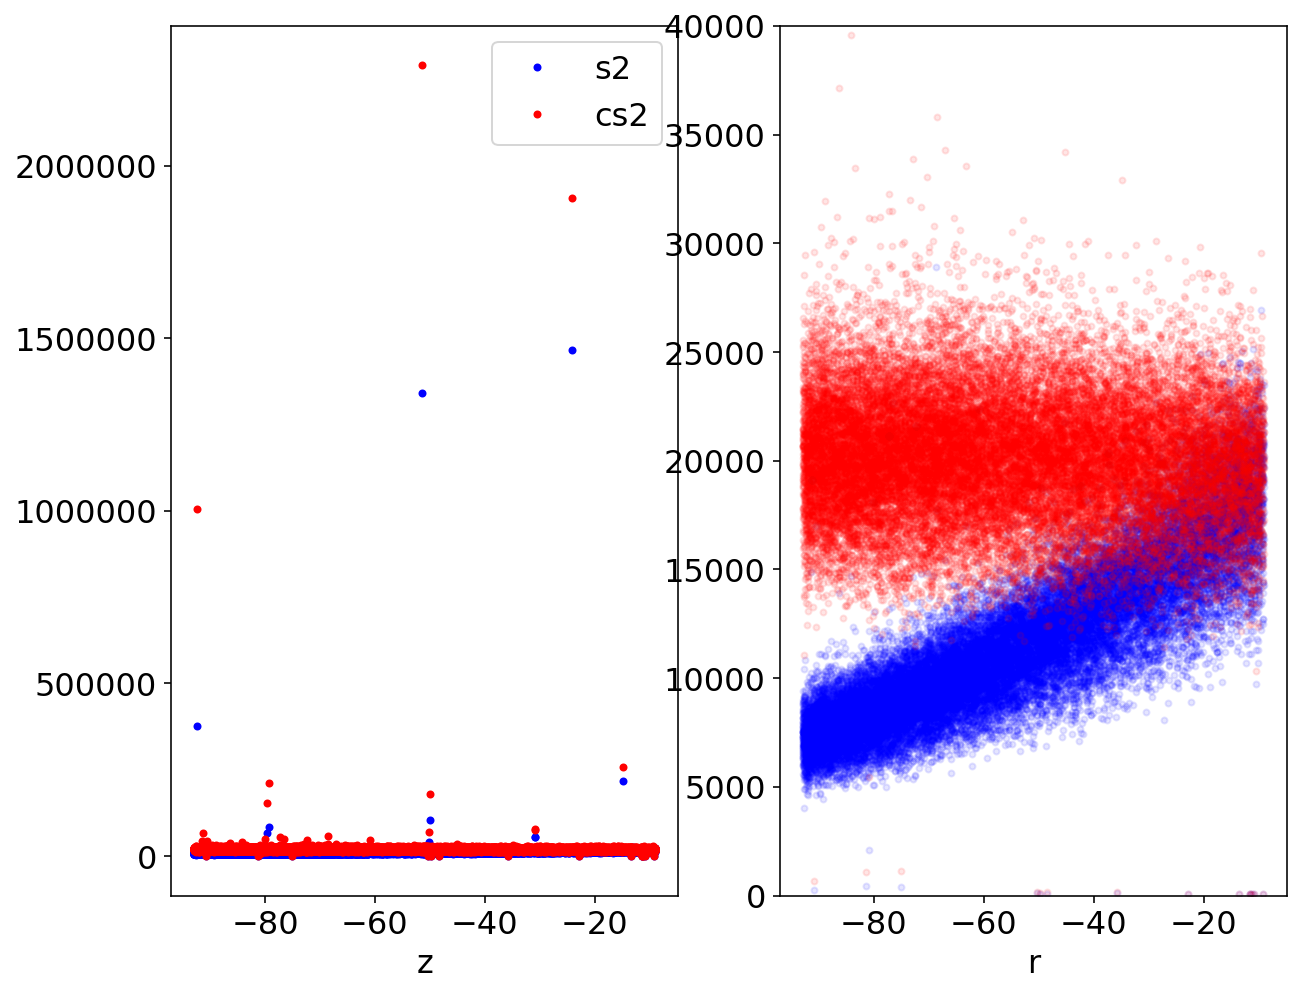

In [39]:
plt.subplot(121)
plt.plot(kr_sr1_cut['z'],kr_sr1_cut['s2'],'.b',label = 's2')
plt.plot(kr_sr1_cut['z'],kr_sr1_cut['cs2'],'.r', label = 'cs2')
plt.legend()
plt.xlabel('z')

plt.subplot(122)
plt.plot(kr_sr1_cut['z'],kr_sr1_cut['s2'],'.b',alpha = 0.1,label = 's2')
plt.plot(kr_sr1_cut['z'],kr_sr1_cut['cs2'],'.r',alpha = 0.1, label = 'cs2')
plt.ylim(0,40000)
plt.xlabel('r')
plt.savefig('./figures/corrections_cs2_s2_z_sr1.png' , bbox_inches='tight')

plt.show()

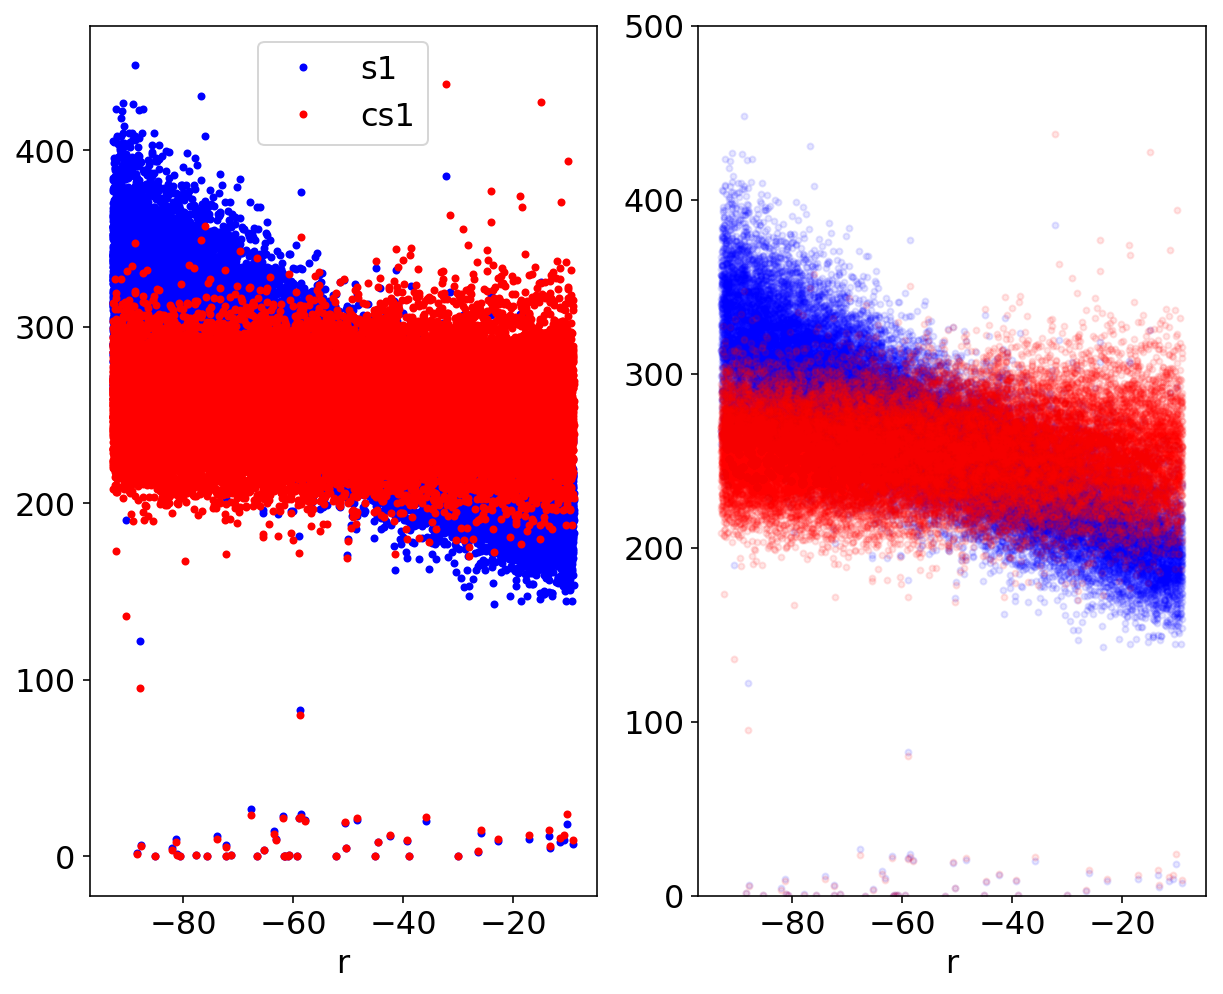

In [40]:
plt.subplot(121)
plt.plot(kr_sr1_cut['z'],kr_sr1_cut['s1'],'.b',label = 's1')
plt.plot(kr_sr1_cut['z'],kr_sr1_cut['cs1'],'.r', label = 'cs1')
plt.legend()
plt.xlabel('r')

plt.subplot(122)
plt.plot(kr_sr1_cut['z'],kr_sr1_cut['s1'],'.b',alpha = 0.1,label = 's1')
plt.plot(kr_sr1_cut['z'],kr_sr1_cut['cs1'],'.r',alpha = 0.1, label = 'cs1')
plt.ylim(0,500)
plt.xlabel('r')
plt.savefig('./figures/corrections_cs1_s1_z_sr1.png' , bbox_inches='tight')

plt.show()

In [41]:
kr_cut.columns.values

array(['alt_s1_interaction_drift_time', 'alt_s1_interaction_z',
       'alt_s2_interaction_s2_range_50p_area',
       'alt_s2_interaction_s2_range_80p_area', 'alt_s2_interaction_x',
       'alt_s2_interaction_y', 'alt_s2_interaction_z',
       'area_before_main_s2', 'cs1', 'cs1_a', 'cs1_a_no_field_corr',
       'cs1_b', 'cs1_b_int_b', 'cs1_b_int_b_no_field_corr',
       'cs1_b_no_field_corr', 'cs1_no_field_corr', 'cs1_tpf_2dfdc', 'cs2',
       'cs2_a', 'cs2_a_bottom', 'cs2_a_top', 'cs2_alpha', 'cs2_bottom',
       'cs2_bottom_alpha', 'cs2_top', 'cs2_top_alpha', 'drift_time',
       'ds_s1_b_n_distinct_channels', 'ds_s1_dt', 'ds_second_s2',
       'event_duration', 'event_number', 'event_time', 'int_a_drift_time',
       'int_a_r_3d_nn', 'int_a_r_correction_3d_nn', 'int_a_r_nn',
       'int_a_x_3d_nn', 'int_a_x_nn', 'int_a_x_pax', 'int_a_y_3d_nn',
       'int_a_y_nn', 'int_a_y_pax', 'int_a_z_3d_nn',
       'int_a_z_correction_3d_nn', 'int_a_z_observed', 'int_a_z_pax',
       'int_b_drif